In [11]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier 
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import  DecisionTreeClassifier,export_graphviz
from xgboost import plot_importance
from matplotlib import pyplot as plt
from collections import Counter
from imblearn.over_sampling import RandomOverSampler

In [12]:
# 缺失值填充
dt = pd.read_csv("dt.csv")
pax_fcny = dt['pax_fcny'].mode()
dt.loc[dt['pax_fcny'].isnull(),'pax_fcny']= pax_fcny[0]
pax_tax = dt['pax_tax'].mode()
dt.loc[dt['pax_tax'].isnull(),'pax_tax']= pax_tax[0]
seg_cabin=dt['seg_cabin'].mode()
dt.loc[dt['seg_cabin'].isnull(),'seg_cabin']=seg_cabin[0]

In [13]:
labels = dt['emd_lable2']
X = dt
X1 = X.drop(['emd_lable2','pax_name'],axis=1)

In [14]:
mm= MinMaxScaler()
# 对测试集和训练集的特征值进行归一化
X2 = mm.fit_transform(X1)
X3=  pd.DataFrame(X2,columns=X1.columns)
# X3.to_csv('X1.csv')

In [15]:
def box_fill(col):
    que = col.quantile(0.75)-col.quantile(0.25)#数据四分之三分位值与四分之一分位值的差
    up_th = col.quantile(0.75) + 1.5*que#上界
    low_th = col.quantile(0.25) - 1.5*que#下界
    def box_change(x):#定义转换函数，如果数字大于上界则用上界值填充，小于下界则用下界值填充。
        if x > up_th:
            return up_th
        elif x < low_th:
            return low_th
        else:
            return x
    return col.map(box_change)
for index in X3:
    X3[index] = box_fill(X3[index])


In [16]:
X4 = pd.DataFrame(X3,columns=X1.columns)
X4.insert(0,'emd_lable2',labels.values)
X4

C:\Users\yaokexin\AppData\Local\Temp\ipykernel_23248\1425414722.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X4.insert(0,'emd_lable2',labels.values)


,emd_lable2,Unnamed: 0,seg_route_to,seg_flight,seg_cabin,pax_fcny,pax_tax,cabin_hf_cnt_m3,cabin_hf_cnt_m6,cabin_hf_cnt_y1,...,pit_pay_cnt_y2,pit_pay_cnt_y3,pit_income_avg_amt_m3,pit_income_avg_amt_m6,pit_income_avg_amt_y1,pit_income_avg_amt_y2,pit_income_avg_amt_y3,pit_pay_avg_amt_m3,pit_pay_avg_amt_m6,pit_pay_avg_amt_y1
0,0.0,0.000000,0.0,0.3750,0.8,0.000596,0.000809,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000043,0.0,0.3750,0.8,0.000392,0.000344,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000085,0.5,0.5625,0.8,0.000057,0.000417,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000128,0.5,0.5625,0.8,0.000319,0.000629,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.000171,0.0,0.6250,0.8,0.000158,0.000393,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30198,0.0,0.288763,0.5,0.5000,0.8,0.000596,0.000705,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30199,0.0,0.288805,0.5,0.5000,0.8,0.000596,0.001018,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30200,0.0,0.288848,0.0,0.3750,0.8,0.000076,0.000381,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30201,0.0,0.288891,0.0,0.6250,0.8,0.000090,0.000391,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
ts1=X4.loc[23432:]
ts1=ts1.reset_index(drop = True)
ts1.to_csv("D:/XGboost/ts1.csv")
ts1

,emd_lable2,Unnamed: 0,seg_route_to,seg_flight,seg_cabin,pax_fcny,pax_tax,cabin_hf_cnt_m3,cabin_hf_cnt_m6,cabin_hf_cnt_y1,...,pit_pay_cnt_y2,pit_pay_cnt_y3,pit_income_avg_amt_m3,pit_income_avg_amt_m6,pit_income_avg_amt_y1,pit_income_avg_amt_y2,pit_income_avg_amt_y3,pit_pay_avg_amt_m3,pit_pay_avg_amt_m6,pit_pay_avg_amt_y1
0,0.0,0.000000,0.0,0.6250,0.8,0.000079,0.000315,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000043,0.5,0.5000,0.8,0.000060,0.000346,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000085,0.0,0.6250,0.8,0.000112,0.000569,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000128,0.5,0.5625,0.8,0.000094,0.000791,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000171,0.0,0.3750,0.8,0.000117,0.000387,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6766,0.0,0.288763,0.5,0.5000,0.8,0.000596,0.000705,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6767,0.0,0.288805,0.5,0.5000,0.8,0.000596,0.001018,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6768,0.0,0.288848,0.0,0.3750,0.8,0.000076,0.000381,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6769,0.0,0.288891,0.0,0.6250,0.8,0.000090,0.000391,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
y = df1['emd_lable2']
x = df1
x = x.drop(['emd_lable2'],axis=1)

In [20]:
ros = RandomOverSampler(random_state=0)#随机过采样
X_resampled, y_resampled = ros.fit_resample(x, y)#使用原始数据的特征变量和目标变量生成过采样数据集
sorted(Counter(y_resampled).items())

[(0.0, 21957), (1.0, 21957)]

In [21]:
gc=X_resampled
gc['emd_lable2']=y_resampled
gc.to_csv("D:/XGboost/gc.csv")
gc

C:\Users\yaokexin\AppData\Local\Temp\ipykernel_23248\4185526843.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  gc['emd_lable2']=y_resampled


,Unnamed: 0,seg_route_to,seg_flight,seg_cabin,pax_fcny,pax_tax,cabin_hf_cnt_m3,cabin_hf_cnt_m6,cabin_hf_cnt_y1,cabin_hf_cnt_y2,...,pit_pay_cnt_y3,pit_income_avg_amt_m3,pit_income_avg_amt_m6,pit_income_avg_amt_y1,pit_income_avg_amt_y2,pit_income_avg_amt_y3,pit_pay_avg_amt_m3,pit_pay_avg_amt_m6,pit_pay_avg_amt_y1,emd_lable2
0,0.000000,0.0,0.3750,0.8,0.000596,0.000809,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000043,0.0,0.3750,0.8,0.000392,0.000344,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000085,0.5,0.5625,0.8,0.000057,0.000417,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000128,0.5,0.5625,0.8,0.000319,0.000629,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000171,0.0,0.6250,0.8,0.000158,0.000393,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43909,0.013913,0.0,0.6250,0.8,0.000098,0.000415,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
43910,0.631428,0.0,0.6250,0.8,0.000166,0.000628,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
43911,0.639623,0.5,0.5000,0.8,0.000040,0.000365,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
43912,0.313986,0.0,0.3750,0.8,0.000178,0.000629,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## 进行模型训练，筛选出对目标列比较有影响的数据列

In [3]:
gc = pd.read_csv("gc.csv")
y =gc['emd_lable2']
x = gc
x = x.drop(['emd_lable2'],axis=1)

[0]	train-auc:0.97481
[1]	train-auc:0.97485
[2]	train-auc:0.97484
[3]	train-auc:0.98164
[4]	train-auc:0.98211
[5]	train-auc:0.98211
[6]	train-auc:0.98229
[7]	train-auc:0.98229
[8]	train-auc:0.98228
[9]	train-auc:0.98228
[10]	train-auc:0.98228
[11]	train-auc:0.98215
[12]	train-auc:0.98256
[13]	train-auc:0.98256
[14]	train-auc:0.98256
[15]	train-auc:0.98256
[16]	train-auc:0.98256
[17]	train-auc:0.98256
[18]	train-auc:0.98256
[19]	train-auc:0.98293
[20]	train-auc:0.98292
[21]	train-auc:0.98292
[22]	train-auc:0.98318
[23]	train-auc:0.98318
[24]	train-auc:0.98323
[25]	train-auc:0.98322
[26]	train-auc:0.98336
[27]	train-auc:0.98334
[28]	train-auc:0.98330
[29]	train-auc:0.98330
[30]	train-auc:0.98330
[31]	train-auc:0.98330
[32]	train-auc:0.98330
[33]	train-auc:0.98329
[34]	train-auc:0.98325
[35]	train-auc:0.98322
[36]	train-auc:0.98329
[37]	train-auc:0.98328
[38]	train-auc:0.98324
[39]	train-auc:0.98323
[40]	train-auc:0.98323
[41]	train-auc:0.98321
[42]	train-auc:0.98320
[43]	train-auc:0.9832

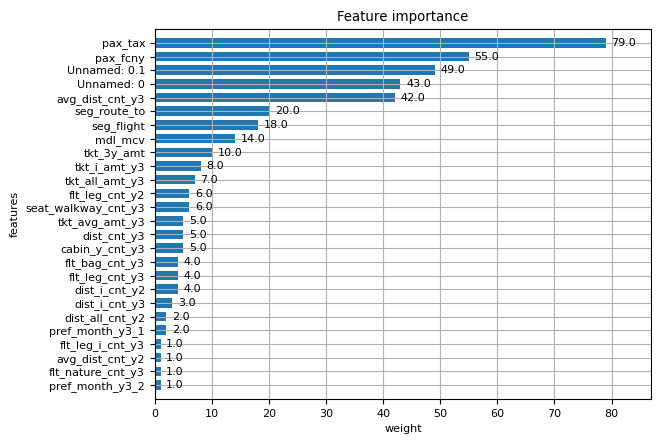

In [6]:
from sklearn import metrics
import xgboost as xgb
# XGBoost训练过程
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split,StratifiedKFold,train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error,roc_auc_score
from xgboost import plot_importance
from matplotlib import pyplot as plt
import xgboost as xgb

# xgboost模型初始化设置
dtrain=xgb.DMatrix(X_train,label=y_train)
dtest=xgb.DMatrix(X_test)
watchlist = [(dtrain,'train')]

# booster:
params={'booster':'gbtree',
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'max_depth':5,
        'lambda':10,
        'subsample':0.75,
        'colsample_bytree':0.75,
        'min_child_weight':2,
        'eta': 0.025,
        'seed':0,
        'nthread':8,
        'gamma':0.15,
        'learning_rate' : 0.01}

# 建模与预测：50棵树
bst=xgb.train(params,dtrain,num_boost_round=50,evals=watchlist)
ypred=bst.predict(dtest)
 
# 设置阈值、评价指标
y_pred = (ypred >= 0.5)*1
print ('Precesion: %.4f' %metrics.precision_score(y_test,y_pred))
print ('Recall: %.4f' % metrics.recall_score(y_test,y_pred))
print ('F1-score: %.4f' %metrics.f1_score(y_test,y_pred))
print ('Accuracy: %.4f' % metrics.accuracy_score(y_test,y_pred))
print ('AUC: %.4f' % metrics.roc_auc_score(y_test,ypred))

ypred = bst.predict(dtest)
print("测试集每个样本的得分\n",ypred)
ypred_leaf = bst.predict(dtest, pred_leaf=True)
print("测试集每棵树所属的节点数\n",ypred_leaf)
ypred_contribs = bst.predict(dtest, pred_contribs=True)
print("特征的重要性\n",ypred_contribs )

xgb.plot_importance(bst,height=0.7,title='Feature importance', ylabel='features',xlabel='weight')
plt.rc('font', family='Arial Unicode MS', size=8)
plt.show()

In [16]:
gc1=gc.loc[0:,['pax_tax','pax_fcny','avg_dist_cnt_y3','seg_flight','tkt_3y_amt','dist_cnt_y3','seat_walkway_cnt_y3','dist_i_cnt_y3','tkt_avg_amt_y3','emd_lable2']]
gc1.to_csv("D:/XGboost/gc1.csv")
gc1

,pax_tax,pax_fcny,avg_dist_cnt_y3,seg_flight,tkt_3y_amt,dist_cnt_y3,seat_walkway_cnt_y3,dist_i_cnt_y3,tkt_avg_amt_y3,emd_lable2
0,0.000809,0.000596,0.000000,0.3750,0.001236,0.000000,0.000000,0.000000,0.012203,0.0
1,0.000344,0.000392,0.347172,0.3750,0.001236,0.000000,0.000000,0.000000,0.024350,0.0
2,0.000417,0.000057,0.000000,0.5625,0.001236,0.000000,0.000000,0.000000,0.012203,0.0
3,0.000629,0.000319,0.754508,0.5625,0.007383,0.030705,0.006993,0.030705,0.024350,0.0
4,0.000393,0.000158,0.000000,0.6250,0.007466,0.040664,0.017483,0.040664,0.012203,1.0
...,...,...,...,...,...,...,...,...,...,...
43909,0.000415,0.000098,0.411954,0.6250,0.001236,0.000000,0.000000,0.000000,0.021259,1.0
43910,0.000628,0.000166,0.700813,0.6250,0.008580,0.057040,0.006993,0.055707,0.024350,1.0
43911,0.000365,0.000040,0.000000,0.5000,0.001236,0.000000,0.000000,0.000000,0.012203,1.0
43912,0.000629,0.000178,0.000000,0.3750,0.008580,0.075018,0.006993,0.075018,0.012203,1.0


In [25]:
ts1 = pd.read_csv("ts1.csv")
ts = pd.read_csv("ts.csv")
ts2=ts1.loc[0:,['pax_tax','pax_fcny','avg_dist_cnt_y3','seg_flight','tkt_3y_amt','dist_cnt_y3','seat_walkway_cnt_y3','dist_i_cnt_y3','tkt_avg_amt_y3']]
ts2['emd_lable2']=ts['emd_lable2']
ts2['pax_name']=ts['pax_name']
ts2.to_csv("D:/XGboost/ts2.csv")
ts2

,pax_tax,pax_fcny,avg_dist_cnt_y3,seg_flight,tkt_3y_amt,dist_cnt_y3,seat_walkway_cnt_y3,dist_i_cnt_y3,tkt_avg_amt_y3,emd_lable2,pax_name
0,0.000315,0.000079,0.393975,0.6250,0.001236,0.00000,0.000000,0.00000,0.024350,0.0,21f0b1c838160ac26cb2c57660bc3fd5
1,0.000346,0.000060,0.000000,0.5000,0.001236,0.00000,0.000000,0.00000,0.012203,0.0,21e0621a85f6db6139ff7cf2d53b4e5d
2,0.000569,0.000112,0.609106,0.6250,0.001236,0.00000,0.000000,0.00000,0.017461,0.0,197b215b23a93b19f391c422eb27f310
3,0.000791,0.000094,0.000000,0.5625,0.004045,0.04216,0.017483,0.04216,0.012203,0.0,92b435f20c6ce2fd5acef7b6ff49b6d0
4,0.000387,0.000117,0.000000,0.3750,0.001236,0.00000,0.000000,0.00000,0.012203,0.0,a38ac8bfe0feb14c0469e2917bc74a05
...,...,...,...,...,...,...,...,...,...,...,...
6766,0.000705,0.000596,0.000000,0.5000,0.001236,0.00000,0.000000,0.00000,0.012203,0.0,d6364954adcfbd58d8beebd686a9fbdc
6767,0.001018,0.000596,0.000000,0.5000,0.001236,0.00000,0.000000,0.00000,0.012203,0.0,150b405be4282907eb7e87f992856ea1
6768,0.000381,0.000076,0.000000,0.3750,0.001236,0.00000,0.000000,0.00000,0.012203,0.0,33b02fadd0d05938b8cc3dfbc735fd10
6769,0.000391,0.000090,0.000000,0.6250,0.001236,0.00000,0.000000,0.00000,0.012203,0.0,29cb3dea4ecce778096484ff2e097f5b


## 查看训练集和验证集的列情况

In [18]:
gc1.info(verbose=True,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43914 entries, 0 to 43913
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   pax_tax              43914 non-null  float64
 1   pax_fcny             43914 non-null  float64
 2   avg_dist_cnt_y3      43914 non-null  float64
 3   seg_flight           43914 non-null  float64
 4   tkt_3y_amt           43914 non-null  float64
 5   dist_cnt_y3          43914 non-null  float64
 6   seat_walkway_cnt_y3  43914 non-null  float64
 7   dist_i_cnt_y3        43914 non-null  float64
 8   tkt_avg_amt_y3       43914 non-null  float64
 9   emd_lable2           43914 non-null  float64
dtypes: float64(10)
memory usage: 3.4 MB


C:\Users\yaokexin\AppData\Local\Temp\ipykernel_6564\2352315568.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  gc1.info(verbose=True,null_counts=True)


In [26]:
ts2.info(verbose=True,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6771 entries, 0 to 6770
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   pax_tax              6771 non-null   float64
 1   pax_fcny             6771 non-null   float64
 2   avg_dist_cnt_y3      6771 non-null   float64
 3   seg_flight           6771 non-null   float64
 4   tkt_3y_amt           6771 non-null   float64
 5   dist_cnt_y3          6771 non-null   float64
 6   seat_walkway_cnt_y3  6771 non-null   float64
 7   dist_i_cnt_y3        6771 non-null   float64
 8   tkt_avg_amt_y3       6771 non-null   float64
 9   emd_lable2           6771 non-null   float64
 10  pax_name             6771 non-null   object 
dtypes: float64(10), object(1)
memory usage: 582.0+ KB


C:\Users\yaokexin\AppData\Local\Temp\ipykernel_6564\3820742093.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  ts2.info(verbose=True,null_counts=True)


## 查看处理完的训练集以及验证集

In [20]:
gc1.head()

,pax_tax,pax_fcny,avg_dist_cnt_y3,seg_flight,tkt_3y_amt,dist_cnt_y3,seat_walkway_cnt_y3,dist_i_cnt_y3,tkt_avg_amt_y3,emd_lable2
0,0.000809,0.000596,0.000000,0.3750,0.001236,0.000000,0.000000,0.000000,0.012203,0.0
1,0.000344,0.000392,0.347172,0.3750,0.001236,0.000000,0.000000,0.000000,0.024350,0.0
2,0.000417,0.000057,0.000000,0.5625,0.001236,0.000000,0.000000,0.000000,0.012203,0.0
3,0.000629,0.000319,0.754508,0.5625,0.007383,0.030705,0.006993,0.030705,0.024350,0.0
4,0.000393,0.000158,0.000000,0.6250,0.007466,0.040664,0.017483,0.040664,0.012203,1.0


In [27]:
ts2.head()

,pax_tax,pax_fcny,avg_dist_cnt_y3,seg_flight,tkt_3y_amt,dist_cnt_y3,seat_walkway_cnt_y3,dist_i_cnt_y3,tkt_avg_amt_y3,emd_lable2,pax_name
0,0.000315,0.000079,0.393975,0.6250,0.001236,0.00000,0.000000,0.00000,0.024350,0.0,21f0b1c838160ac26cb2c57660bc3fd5
1,0.000346,0.000060,0.000000,0.5000,0.001236,0.00000,0.000000,0.00000,0.012203,0.0,21e0621a85f6db6139ff7cf2d53b4e5d
2,0.000569,0.000112,0.609106,0.6250,0.001236,0.00000,0.000000,0.00000,0.017461,0.0,197b215b23a93b19f391c422eb27f310
3,0.000791,0.000094,0.000000,0.5625,0.004045,0.04216,0.017483,0.04216,0.012203,0.0,92b435f20c6ce2fd5acef7b6ff49b6d0
4,0.000387,0.000117,0.000000,0.3750,0.001236,0.00000,0.000000,0.00000,0.012203,0.0,a38ac8bfe0feb14c0469e2917bc74a05
